In [2]:
# Import the necessary packages
import os
import numpy as np
import numpy.matlib
import math
from itertools import *
import more_itertools
from scipy import signal
from scipy.fftpack import fftshift
from scipy.io import wavfile
import matplotlib.pyplot as plt
import pyfftw
import simplespectral
 
    

##### for conventional network training and cubemx implementation-validation we need
#####     tensorflow as tf      from tensorflow import keras
##### for cubemx quantization we need
#####     tensorflow as tf      import keras 
##### for nnom quantization we need
#####     tensorflow.compat.v1 as tf   disable_v2_behavior  enable_eager_execution    from tensorflow import keras

from sklearn.model_selection import train_test_split
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
#tf.enable_eager_execution()
from tensorflow import keras
#import keras



Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# parameters
user = "Parham"
fs = 16000;
filesN = 1132;
angleN = 8;
micN= 2;
windowIncrease = 0.1 #in sec
windowSize = 5 #in sec
filterOrder = 10
filterBand = [200,5000] #in Hertz
fftWindowN = 257 # singlesided
featureType = "magnitude"
speakerType = ["cmu_us_bdl_arctic", "cmu_us_clb_arctic", "cmu_us_jmk_arctic"]#, "cmu_us_bdl_arctic", "cmu_us_clb_arctic", "cmu_us_jmk_arctic"] # , "cmu_us_ksp_arctic", "cmu_us_rms_arctic", "cmu_us_slt_arctic"
speakerTypeN = 3
if user == "Felix":
    folderPath = "./../../../../Shared/SoundLocalization/speech_database/" + str(math.ceil(fs/1000)) + "khz" + "/"
else:
    folderPath = "./../Polybox/SoundLocalization/speech_database/" + str(math.ceil(fs/1000)) + "khz"
#audioCh1Data = np.ndarray([0,windowSize*fs])
#audioCh2Data = np.ndarray([0,windowSize*fs])
readBatchOn = True;
filterOn = False;

In [4]:
# read in data

# init
audioCh1Data = []
audioCh2Data = []
Y = []
count = 0
folderN = len(speakerType)
if fs == 16000:
    if featureType == "raw":
        samplesN = 113599;
        data = np.zeros((samplesN, angleN, filesN, micN, speakerTypeN), dtype = np.int16)
    if featureType == "magnitude":
        samplesN = 113851;
        fftWindowT = int(samplesN / fftWindowN);
        data = np.zeros((speakerTypeN,filesN, angleN, fftWindowT, fftWindowN, micN), dtype = np.int16) # fftWindowN, fftWindowT, angleN, filesN, speakerTypeN, micN

# read data
for folder_i in range(speakerTypeN):
    if readBatchOn:

        # read data file
        print ("read data file")
        fs, data_i = wavfile.read(folderPath + "/" + speakerType[folder_i] + "_" + featureType + ".wav")
        print ("finish load data file")
        print (np.shape(data_i))
        
        # 
        if filterOn:
            sos = signal.butter(filterOrder, filterBand, 'bp', fs=fs, output='sos')
            data_i[:,0] = signal.sosfilt(sos, data_i[:,0])
            data_i[:,1] = signal.sosfilt(sos, data_i[:,1])
            
        # reshape into invidual databases
        if featureType == "raw":
            data_i = np.reshape(data_i, (samplesN, angleN, filesN, micN))
        if featureType == "magnitude":            
            data_i = np.reshape(data_i, (filesN, angleN, fftWindowT, fftWindowN, micN))
            print (np.shape(data_i))
            
        # merge into one database
        data[folder_i,:,:,:,:,:] = data_i
        
        print("data reshaped")
        print(np.shape(data))
        
    else:
        for i in os.listdir(folderPath + folder):           # iteration over all single data files
            
            # get meta data
            deg = int(i[i.rfind("_")+1:i.find("degree")])/180*math.pi # read angle
            dist = 1 # read distance
            number = int(i[i.rfind("arctic")+7:i.find(str(math.ceil(fs/1000)) + "k")-1]) # read file number
            
            # read data file
            tempData = data
            audioCh1 = data[:,0]
            audioCh2 = data[:,1]
            
            # filter
            if filterOn:
                sos = signal.butter(filterOrder, filterBand, 'bp', fs=fs, output='sos')
                audioCh1 = signal.sosfilt(sos, audioCh1)
                audioCh2 = signal.sosfilt(sos, audioCh2)
        
            # window (rectangular)
            tempData = list(more_itertools.windowed(audioCh1, n=int(windowSize*fs), step=int(windowIncrease*fs)))
            tempData.pop()
            audioCh1Data.extend(tempData)
        
            tempData = list(more_itertools.windowed(audioCh2, n=int(windowSize*fs), step=int(windowIncrease*fs)))
            tempData.pop()
            audioCh2Data.extend(tempData)
        
            # resphape into one array
            dataSize = (np.shape(tempData))[0]
            Y.extend(list(np.repeat([dist,deg],dataSize))) 
        
            # log
            print (i)
            
print ("finished all data files' load")

read data file
finish load data file
(1031034656, 2)
(1132, 8, 443, 257, 2)
data reshaped
(3, 1132, 8, 443, 257, 2)
read data file
finish load data file
(1031034656, 2)
(1132, 8, 443, 257, 2)
data reshaped
(3, 1132, 8, 443, 257, 2)
read data file
finish load data file
(1031034656, 2)
(1132, 8, 443, 257, 2)
data reshaped
(3, 1132, 8, 443, 257, 2)
finished all data files' load


(3, 1132, 8, 443, 257, 2)
(27168, 1)
(27168, 96, 257, 2)


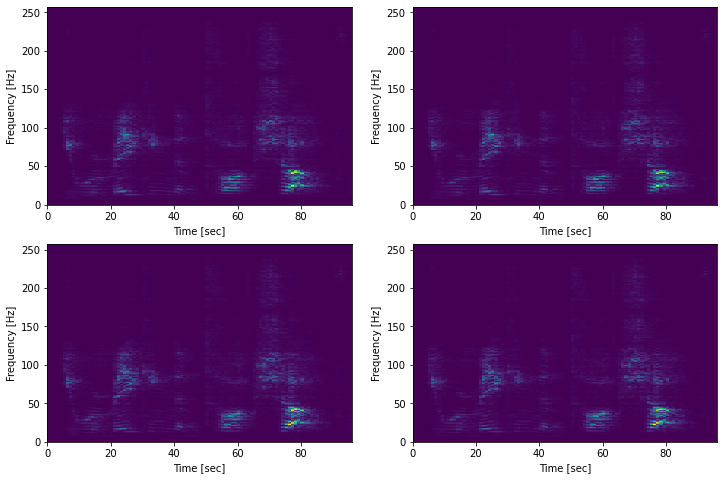

In [5]:
# calculate features
                        # speaker, file number, angle, time bins, frequency bins, channel

# clip dataset to just 3sec of data
fftWindowT_clipped = 96;
data_clipped = data[:,:,:,0:0+fftWindowT_clipped,:,:]
# show dimensions
print (np.shape(data)) 

# visualize features
plt.figure(figsize=(12, 8))
plt.subplot (221)
plot_data = data_clipped[0,1131,0,:,:,0]
plot_data = plot_data / np.amax(plot_data)
plt.pcolormesh(plot_data.transpose())
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.subplot (222)
plot_data = data_clipped[0,1131,0,:,:,1]
plot_data = plot_data / np.amax(plot_data)
plt.pcolormesh(plot_data.transpose())
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

# prepare features for neural network
X = np.reshape(data_clipped, (angleN * filesN * speakerTypeN, fftWindowT_clipped, fftWindowN, micN))

plt.subplot (223)
plot_data = X[9048,:,:,0]
plot_data = plot_data / np.amax(plot_data)
plt.pcolormesh(plot_data.transpose())
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.subplot (224)
plot_data = X[9048,:,:,1]
plot_data = plot_data / np.amax(plot_data)
plt.pcolormesh(plot_data.transpose())
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

# get meta data
deg = np.linspace(0, 315, angleN)
deg = np.matlib.repmat(deg, 1, filesN  * speakerTypeN).transpose()

# prepare lables for neural network
#Y = np.vstack((deg.T, dist.T)).T
Y = deg
print (np.shape(Y)) # speaker-angle-file number, angle, distance
print (np.shape(X)) # speaker-angle-file number, time bins, frequency bins, channel


In [6]:
BothMics = True
if BothMics:
    XFFTSmall = X[:,:,0:257:4,:]
else:
    XFFTSmall = X[:,:,0:257:4,0].reshape([X.shape[0],96,65,1])
    

X_train, X_validate, Y_train, Y_validate = train_test_split(XFFTSmall, Y, test_size = 0.2, random_state = 2)

Y_train = Y_train/45
Y_train = keras.utils.to_categorical (Y_train,8)
Y_validate = Y_validate/45
Y_validate = keras.utils.to_categorical (Y_validate,8)

print (np.shape(X_train))
print (np.shape(X_validate))
print (np.shape(Y_train))
print (np.shape(Y_validate))

X_train = X_train.astype('float32')
X_validate = X_validate.astype('float32')
Y_train = Y_train.astype('float32')
Y_validate = Y_validate.astype('float32')

(21734, 96, 65, 2)
(5434, 96, 65, 2)
(21734, 8)
(5434, 8)


In [7]:
# Define batchsize and number of epochs
batchSize = 64
nEpochs = 10

# Declare the sequential model and design your multi-layer perceptron
model = keras.models.Sequential()

#model.add (keras.layers.InputLayer(input_shape=X_train.shape[1:]))

model.add(keras.layers.Conv2D(8, (3, 3), padding='same',input_shape=X_train.shape[1:]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(1,8)))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(8, (3, 3), padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(1,4)))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(8, (3, 3), padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(1,2)))
model.add(keras.layers.Dropout(0.2))

#model.add(keras.layers.Reshape((fftWindowT_clipped,8)))
#model.add(keras.layers.Bidirectional(keras.layers.GRU(4,activation='tanh',return_sequences=True),merge_mode='mul'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dense(16))
model.add(keras.layers.Dense(8))
model.add(keras.layers.Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train your model
model.fit(X_train, Y_train, epochs = nEpochs , batch_size = batchSize)


Epoch 1/10
340/340 [==============================] - 70s 207ms/step - loss: 1.4980 - accuracy: 0.4009
Epoch 2/10
340/340 [==============================] - 73s 215ms/step - loss: 0.5991 - accuracy: 0.7452
Epoch 3/10
340/340 [==============================] - 73s 214ms/step - loss: 0.3243 - accuracy: 0.8725
Epoch 4/10
340/340 [==============================] - 73s 215ms/step - loss: 0.1780 - accuracy: 0.9359
Epoch 5/10
340/340 [==============================] - 74s 219ms/step - loss: 0.1164 - accuracy: 0.9600
Epoch 6/10
340/340 [==============================] - 76s 223ms/step - loss: 0.0760 - accuracy: 0.9742
Epoch 7/10
340/340 [==============================] - 74s 217ms/step - loss: 0.0554 - accuracy: 0.9811
Epoch 8/10
340/340 [==============================] - 73s 214ms/step - loss: 0.0469 - accuracy: 0.9840
Epoch 9/10
340/340 [==============================] - 75s 221ms/step - loss: 0.0359 - accuracy: 0.9876
Epoch 10/10
340/340 [==============================] - 74s 217ms/step - l

In [10]:
model.build()
model.summary ()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 65, 8)         152       
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 65, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 96, 65, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 8, 8)          0         
_________________________________________________________________
dropout (Dropout)            (None, 96, 8, 8)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 8, 8)          584       
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 8, 8)          3

In [15]:
model.evaluate (X_validate,Y_validate)

170/170 [==============================] - 2s 13ms/step - loss: 0.0044 - accuracy: 0.9983


[0.004418543074280024, 0.9983437657356262]

In [16]:
model.evaluate (X_train,Y_train)

680/680 [==============================] - 10s 14ms/step - loss: 0.0042 - accuracy: 0.9984


[0.0041593569330871105, 0.9984356164932251]

In [13]:
model.save ('FinalWithoutGRU_forNNoM.h5')

In [ ]:
model = tf.keras.models.load_model('FinallWithoutGRU.h5')

In [ ]:
np.save('X_validate.npy',X_validate[0:100,:,:,:])
np.save('Y_validate.npy',Y_validate[0:100,:])

In [ ]:
np.save('X_validateBig.npy',X_validate)
np.save('Y_validateBig.npy',Y_validate)

In [ ]:
np.save('X_validateBigNormalized.npy',X_validate/32768)

In [ ]:
np.save('X_train.npy',X_train)
np.save('Y_train.npy',Y_train)

In [ ]:
model = tf.keras.models.load_model('FinalWithoutGRU_forQuantization.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quant_model = converter.convert()

with open("TFQuantized.tflite", "wb") as f:
    f.write(quant_model)

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])